In [12]:
import numpy as np
import sklearn,sklearn.datasets,utils
%matplotlib inline

# Principal Component Analysis

In this exercise, we will experiment with two different techniques to compute the PCA components of a dataset:

* **Standard PCA**: The standard technique based on eigenvalue decomposition.

* **Iterative PCA**: A technique that iteratively optimizes the PCA objective.

We consider a random subset of the Labeled Faces in the Wild (LFW) dataset, readily accessible from sklearn, and we apply some basic preprocessing to discount strong variations of luminosity and contrast.

In [13]:
X = sklearn.datasets.fetch_lfw_people(resize=0.5)['images']
X = X[np.random.mtrand.RandomState(1).permutation(len(X))[:150]]*1.0
X = X - X.mean(axis=(1,2),keepdims=True)
X = X / X.std(axis=(1,2),keepdims=True)
print(X.shape)

(150, 62, 47)


Two functions are provided for your convenience and are available in `utils.py` that is included in the zip archive. The functions are the following:

* **`utils.scatterplot`** produces a scatter plot from a two-dimensional data set.

* **`utils.render`** takes an array of data points or objects of similar shape, and renders them in the IPython notebook.

Some demo code that makes use of these functions is given below.

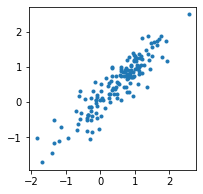

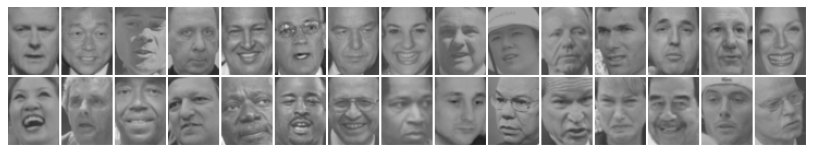

In [14]:
utils.scatterplot(X[:,32,20],X[:,32,21]) # Plot relation between adjacent pixels
utils.render(X[:30],15,2,vmax=5)         # Display first 10 examples in the data

## PCA with Eigenvalue Decomposition (15 P)

Principal components can be found by solving the eigenvalue problem

$$
S \boldsymbol{w} = \lambda \boldsymbol{w}.
$$

where  $S = \sum_{k=1}^N (\boldsymbol{x}_k - \boldsymbol{m}) (\boldsymbol{x}_k - \boldsymbol{m})^\top$ is the scatter matrix, and where $\boldsymbol{m} = \frac1N \sum_{k=1}^N \boldsymbol{x}_k$ is the mean vector.

**Tasks:**

* **Compute the principal components of the data using the function `numpy.linalg.eigh`.**
* **Measure the computational time required to find the principal components. Use the function `time.time()` for that purpose. Do *not* include in your estimate the computation overhead caused by loading the data, plotting and rendering.**
* **Plot the projection of the dataset on the first two principal components using the function `utils.scatterplot`.**
* **Visualize the 60 leading principal components using the function `utils.render`.**

Note that if the algorithm runs for more than 1 minute, there may be some error in your implementation.

In [15]:
from numpy import linalg as LA
import time

import matplotlib.pyplot as plt

In [230]:
class PCA_eighvalue:
    #size of dimension
    n_dimension = 0
    
    #number of data points to be process
    n_data_point = 0
    
    #original data
    x = None
    
    #Mean vector of the data
    mean_vector = None
    
    #subtract between X and the mean
    sub_x_mean = None
    
    #the S matrix that will use in the ecuation Sw = (\lambda)w
    s_matrix = None
    
    #way of calculate the S matrix
    s_type = 'scatter_matrix'
    
    #eigh value obtained from the S matrix
    eigh_value = None
    
    #All the eigh vectors obtained from the S matrix 
    #one column is one vector
    eigh_vect_full = None
    
    #top eigh values that will be used to calculate the convertions
    eigh_vect_current = None
    
    #The matrix expeted is (N(x?)+) where N is the number of datapoint and x? dimension that data and 
    #thus will be flatten in a vector style
    def __init__(self, X):
        if(len(X.shape) > 2):
            final_dimension = 1
            for i in range(1, len(X.shape)):
                final_dimension *= X.shape[i]
            self.x = X.reshape([X.shape[0], final_dimension]).T
        else:
            self.x = X.T
            
        self.n_dimension = self.x.shape[0]
        self.n_data_point = self.x.shape[1]
        
        #calculate some values that are using the lifecycle of the PCA algorithm
        self.calculate_mean_vector()
        self.calculate_diff_x()

    #calculate the mean vector to calculate the next matrix
    def calculate_mean_vector(self):        
        self.mean_vector = self.x.mean(axis = 1).reshape([self.n_dimension, 1])
        return self.mean_vector
        
    #calculate the diffence between the the X_i and the Mean
    def calculate_diff_x(self):
        self.sub_x_mean = self.x - self.mean_vector
        return self.sub_x_mean
    
    #calculate the scatter_matrix using 
    def scatter_matrix(self):
        scatter = np.zeros([self.n_dimension, self.n_dimension])
        for x_tmp in self.sub_x_mean.T:
            x_k = x_tmp.reshape([self.n_dimension,1])
            scatter += np.matmul(x_k, x_k.T)
        return scatter
    
    #calculate the cov_matrix using the original data 
    def cov_matrix(self):
        return np.cov(self.x)
    
    #calculate the s_matrix using the scatter_matrix or cov_matrix depends on the s_type
    def calculate_S_matrix(self, s_type='scatter_matrix'):
        self.s_matrix = getattr(self, s_type)()
        return self.s_matrix
    
    #calculte the eigh vector of s_matrix using np.linalg.eigh 
    def calculate_eigh(self):
        value, vector = np.linalg.eigh(self.s_matrix)
        idx = value.argsort()[::-1] # Sort descending and get sorted indices
        self.eigh_value = value[idx] # Use indices on eigv vector
        self.eigh_vect_full = vector[:,idx] # Use indices on eigv vectors to organize the matrix
        #self.eigh_value = value
        #self.eigh_vect_full = vector
        return self.eigh_vect_full
       
    # validate and plot if everything looks ok
    def validate(self):
        cov = self.cov_matrix()
        value_c, vector_c = LA.eigh(cov)
        idx = value_c.argsort()[::-1] # Sort descending and get sorted indices
        value_c = value_c[idx] # Use indices on eigv vector
        vector_c = vector_c[:,idx] # 
        proportion = np.mean(self.s_matrix/cov)
        
        #np.testing.assert_array_almost_equal(proportion, self.n_data_point - 1 )

        # Calculate the variance explained on each of those components
        variance_explained = np.array([(i/sum(self.eigh_value))*100 for i in self.eigh_value])
        #print(variance_explained)
        # Calculate the cumulative sum of variance explained
        cumulative_variance_explained = np.cumsum(variance_explained)
        #print(cumulative_variance_explained)
        plt.style.use("ggplot")
        plt.rcParams["figure.figsize"] = (12,8)
        plt.plot(np.arange(0, cumulative_variance_explained.shape[0]), cumulative_variance_explained)
        plt.show()
        plt.style.use("ggplot")
        plt.rcParams["figure.figsize"] = (12,8)
        plt.plot(np.arange(0, variance_explained.shape[0]), variance_explained)
        plt.show()
        return
        
    # Get the first N eighvector that is the reduce dimision matrix
    def get_submatrix_eigh(self, first, last):
        self.eigh_vect_current = self.eigh_vect_full[:, first:last]
        return self.eigh_vect_current
        
    def get_top_eigh(self, last=60):
        return self.get_submatrix_eigh(first=0, last=last)
    
    def get_n_eigh(self, index):
        return self.get_submatrix_eigh(first=index, last=index+1)
        
    # calculate the projection in the reduced space X^_n = W^T * (X_n − mean(X)), W is the eighvector
    def calculate_projection(self, W, sub_x_mean):
        return  np.matmul(W.T, sub_x_mean)
    
    #do the reconstruction of the data to be use 
    def reconstruction(self, W, projection):
        return np.matmul(W, projection) + self.mean_vector
    
    #plot all the images that are in the matrix     
    def plot_all_image(self, matrix, rows=10, columns=15, vmax=5):
        utils.render(matrix,columns,rows,vmax=vmax)  
        return
        
        
    def execute(self):
            
        before = time.time()
        self.calculate_S_matrix(self.s_type)
        self.calculate_eigh()
        print(time.time() - before)
        #self.validate()
        result = np.zeros([2, self.n_data_point])
        #for i in range(2):
        #    W = self.get_n_eigh(i)
        #    x_k = self.sub_x_mean
        #    projection = self.calculate_projection(W, x_k)
        #    print(projection.shape)
        #    #tmp = self.reconstruction(W, projection)
        #    result[i] = projection

        W = self.get_top_eigh(last=2)
        x_k = self.sub_x_mean
        projection = self.calculate_projection(W, x_k)
        print(projection.shape)
        #tmp = self.reconstruction(W, projection)
        return projection
        
        

        
        
    def __str__(self):
        return ('dimensions: {0}\n' + 
                'data_points: {1}\n' + 
                'X_shape: {2}\n' +
                'mean_vector: {3}\n' +
                'sub_x_mean: {4}\n' +
                'S matrix: {5}\n' +
                'eigh values: {6}\n' +
                'eigh vectors: {7}\n'
               ).format(
                self.n_dimension, 
                self.n_data_point, 
                self.x.shape,
                self.mean_vector.shape,
                self.sub_x_mean.shape,
                self.s_matrix.shape,
                self.eigh_value.shape,
                self.eigh_vect_full.shape
               )
        
        
pca_ = PCA_eighvalue(X)
lala = pca_.execute()
print(pca_)

5.774856805801392
(2, 150)
dimensions: 2914
data_points: 150
X_shape: (2914, 150)
mean_vector: (2914, 1)
sub_x_mean: (2914, 150)
S matrix: (2914, 2914)
eigh values: (2914,)
eigh vectors: (2914, 2914)



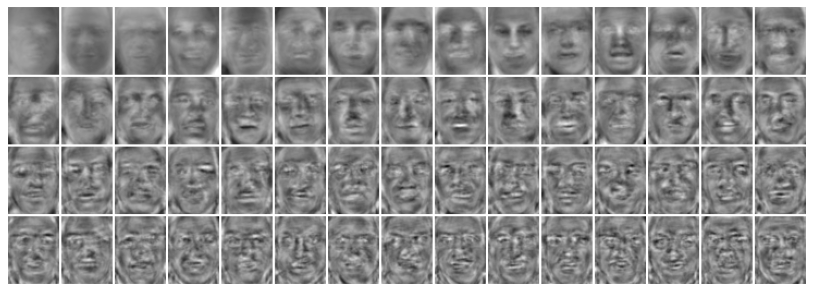

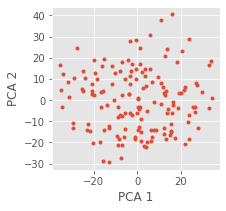

In [232]:
w = 15
h = 4

utils.render(pca_.eigh_vect_full[:, :60].T,w,h, vmax=0.1)  

    
_a = lala[0]
_b = lala[1]
utils.scatterplot(_a,_b, xlabel='PCA 1',ylabel='PCA 2')

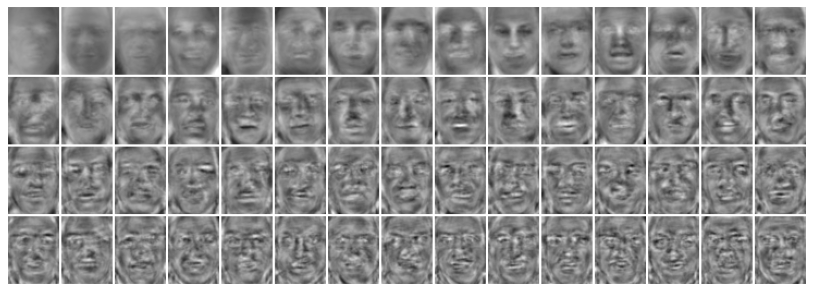

5.850027084350586


In [235]:
from numpy import linalg as LA
import time

import matplotlib.pyplot as plt

#na = np.newaxis
#def pca(X):
before = time.time()

X_prima = X.reshape([X.shape[0], X.shape[1]*X.shape[2]])

M = X_prima.mean(axis=0)

X_diff = X_prima - M

length = M.shape[0]
S = np.zeros([length, length])
for X_k in X_diff:
    S += np.matmul(X_k.reshape([length,1]), X_k.reshape([length, 1]).T)

value, vector = LA.eigh(S)
idx = value.argsort()[::-1] # Sort descending and get sorted indices
value = value[idx] # Use indices on eigv vector
vector = vector[:,idx] # 

#validate the curve of eighvalues and the eighvalues are correctly calculated
#cov = np.cov(X_prima.T)
#value_c, vector_c = LA.eigh(cov)
#idx = value_c.argsort()[::-1] # Sort descending and get sorted indices
#value_c = value_c[idx] # Use indices on eigv vector
#vector_c = vector_c[:,idx] # 
#print(X_prima.shape)
#print(S.shape)
#print(cov.shape)
#print('promedio: '+str(np.mean(S/cov)))
#print('value_diff: '+str(np.mean(value/value_c)))

# Calculate the variance explained on each of those components
#print(value)
#print(vector.shape)
#variance_explained = [(i/sum(value))*100 for i in value]
#print(variance_explained)
# Calculate the cumulative sum of variance explained
#cumulative_variance_explained = np.cumsum(variance_explained)
#print(cumulative_variance_explained)
#plt.style.use("ggplot")
#plt.rcParams["figure.figsize"] = (12,8)
#plt.plot(np.arange(0, cumulative_variance_explained.shape[0]), cumulative_variance_explained)
#plt.show()
w = 15
h = 4

utils.render(vector[:, :60].T,w,h, vmax=0.1)  



after = time.time()
print(after - before)
#return value, vector, code, (after- before)
    
#pca(X)

(150, 2914)
(2914, 2)
(150, 2)


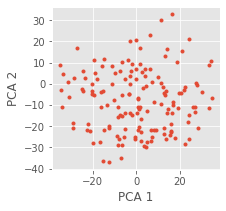

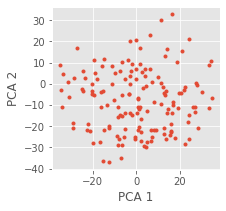

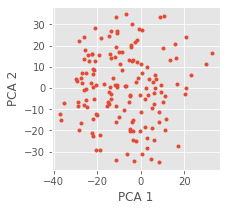

[[-8.46742646e+00 -1.12032214e+01]
 [ 3.36241988e+00 -2.93427113e+01]
 [-2.00130552e+01 -2.81620340e+01]
 [-1.85423756e-02  6.73690626e+00]
 [ 9.84994521e+00  2.95486161e+00]
 [-2.98349727e+00 -1.36307069e+01]
 [ 1.91640618e+01 -1.12576144e+01]
 [ 1.25567798e+01 -2.39207909e+01]
 [-3.45477720e+01 -2.98021016e+00]
 [-1.96381480e+01  1.10961718e+01]
 [ 1.87806284e+01  1.02043154e+01]
 [-1.37034443e-01  2.06528379e+01]
 [ 1.67422855e+01 -8.71601941e+00]
 [-2.01382450e+01 -3.52075358e+00]
 [ 8.27284608e+00 -2.16320056e+01]
 [-1.34574830e+01 -1.01677513e+01]
 [-6.53083925e+00  1.03623860e+01]
 [ 1.95617104e+01 -4.54516946e+00]
 [-1.12180409e+01  2.36879924e-02]
 [-2.84947755e+01  2.69867335e+00]
 [-5.37348688e+00  2.06724568e+00]
 [-1.46420041e+01  1.14620007e+01]
 [ 1.38872973e+00 -1.20172196e+01]
 [ 1.30190726e+01 -5.48724432e+00]
 [-3.09794808e+00  3.54981903e+00]
 [-3.55936724e+00 -4.76042473e+00]
 [ 1.34310231e+01 -3.57506374e+00]
 [-2.78372531e+00  2.02021471e+01]
 [ 6.15221322e+00  2

In [775]:

#tmp = np.dot(vector.T, X_diff.T)
print(X_prima.shape)
print(vector[:,:2].shape)


data = np.matmul(vector[:,:2].T, X_prima.T).T

print(data.shape)


_a = data[:, 0]
_b = data[:, 1]
utils.scatterplot(_a,_b, xlabel='PCA 1',ylabel='PCA 2')



data = np.matmul(X_prima, vector[:,:2])

_a = data[:, 0]
_b = data[:, 1]
utils.scatterplot(_a,_b, xlabel='PCA 1',ylabel='PCA 2')
utils.scatterplot(_b, _a, xlabel='PCA 1',ylabel='PCA 2')

print(data)

(150, 60)
(60, 2914)


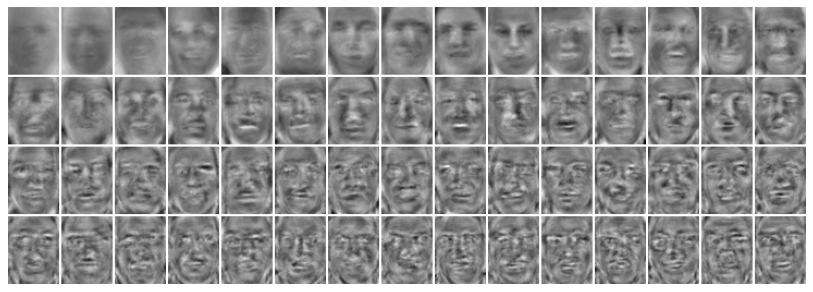

In [234]:
n_components=60
from sklearn.decomposition import PCA
pca = PCA(n_components=n_components)
pca.fit(X_prima)
trans = pca.transform(X_prima)


print(trans.shape)
#_a = trans[:, 0]
#_b = trans[:, 1]
#utils.scatterplot(_a,_b, xlabel='PCA 1',ylabel='PCA 2')
#utils.scatterplot(_b, _a, xlabel='PCA 1',ylabel='PCA 2')
eigh_vec = pca.components_

print(eigh_vec.shape)

final_good = pca.inverse_transform(trans)
utils.render(pca.components_[:60],15,4,vmax=0.1)  

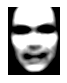

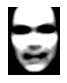

-1.6755562691048004e-10
0.3575602288115407
-0.3794535527434818


In [895]:
n_eigh = 60

eigh_v = eigh_vec.T

def go_back_one_by_one(X_call, M, eigh_v, n_eigh=60):
    mean = M.reshape([1,2914])
    final = np.zeros([n_eigh, X_call.shape[0]])
    for i in range(n_eigh):
        w_i_t = eigh_v[:, i].reshape([1, 2914])
        w_i = eigh_v[:, i].reshape([2914, 1])
        x_trans = np.matmul(w_i_t, X_call)
        x_new = np.matmul(w_i, x_trans)

        x_inv_tras = (x_new.T + mean)
        final[i] = x_inv_tras[0]
    #utils.render(final,15,int(n_eigh/15),vmax=5)  
    
    tmp = np.zeros([1, 2914])
    for i in range(40, n_eigh):
        tmp += final[i]
    utils.render(tmp,1,1,vmax=5)
    
    
    
def go_back(X_call, M, eigh_v, n_eigh=60):
    mean = M.reshape([1,2914])
    print("lalal")
    print(eigh_v[:, :n_eigh].shape)
    x_i_diff = X_call - mean.T
    w_i_t = eigh_v[:, :n_eigh].T
    w_i = eigh_v[:, :n_eigh]

    x_trans = np.matmul(w_i_t, x_i_diff)
    
    x_new = np.matmul(w_i, x_trans)

    x_inv_tras = (x_new.T + mean)
    
    utils.render(x_inv_tras, 15, 10, vmax=5)  
    return x_inv_tras
    
go_back_one_by_one(X_diff.T, M, eigh_vec.T)
go_back_one_by_one(X_diff.T, M, vector)


#a = go_back(X_prima.T, M, vector)
#b = go_back(X_prima.T, M, eigh_vec.T)

print(np.mean(a - b))

print(np.max(a - b))

print(np.min(a - b))


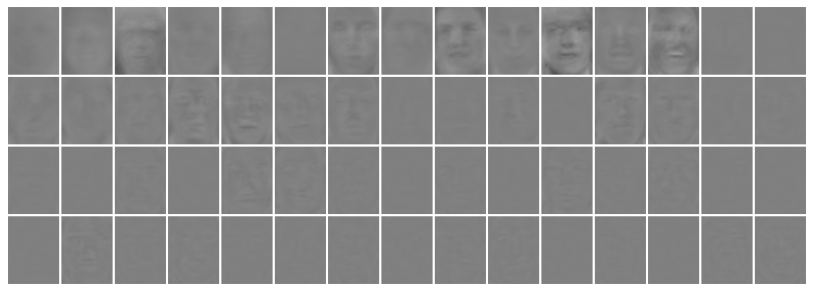

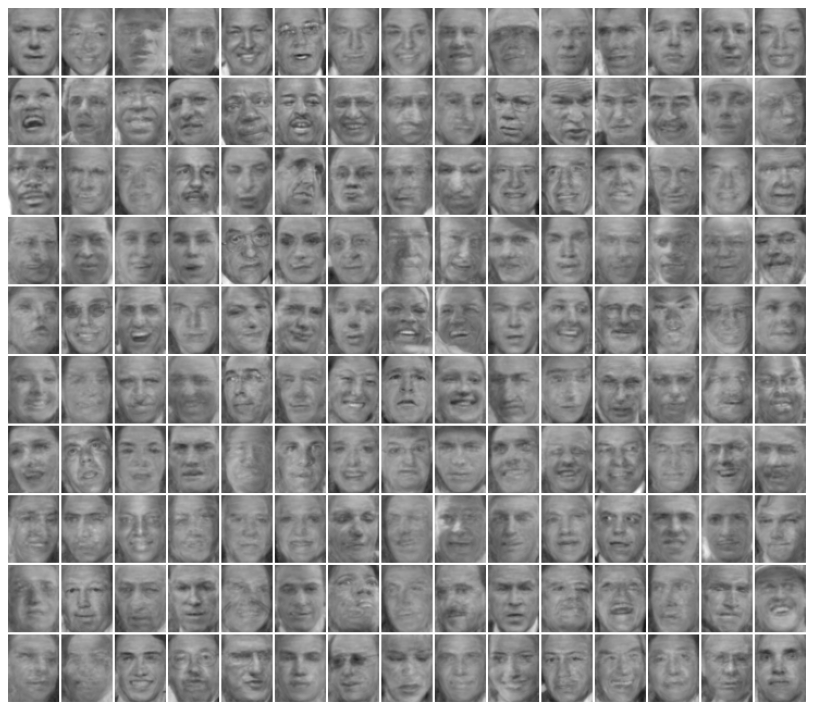

ValueError: operands could not be broadcast together with shapes (150,2914) (2914,150) 

In [837]:
n_eigh = 60



X_call = X_prima.T
C = np.zeros_like(M)
#C = M * -1 
C = X_diff.sum(axis=0)*-1


final = np.zeros([n_eigh, X_call.shape[0]])
for i in range(n_eigh):
    B = vector[:, i].reshape([2914, 1])
    B_pre = np.matmul(B, B.T)
    
    result = np.matmul(B_pre, X_call).T + C

    final[i] = result[0]
    

#print(final.shape)
#tmp = np.cumsum(final, axis=0)
#utils.render(tmp,1,2,vmax=5)  
utils.render(final,15,int(n_eigh/15),vmax=5)  
    
B = vector[:, :n_eigh]

B_pre = np.matmul(B, B.T)

final = np.matmul(B_pre, X_call).T + C

ancho = 15
alto = 10#int(n_eigh/15)
utils.render(final,ancho,alto,vmax=5)  

_final = final - final_good

print(np.mean(_final))

#n_eigh = 2
#final = np.zeros([2, 2914])
#for i in range(n_eigh):
#    B = vector[:, :i]
#
#    B_pre = np.matmul(B, B.T)
#
#    result = np.matmul(B,B_pre).T + C
#    final[i] = result[i]


#a = final.reshape([2, 62, 47])
#utils.scatterplot(a[:,32,20],a[:,32,21], xlabel='PCA 1',ylabel='PCA 2')



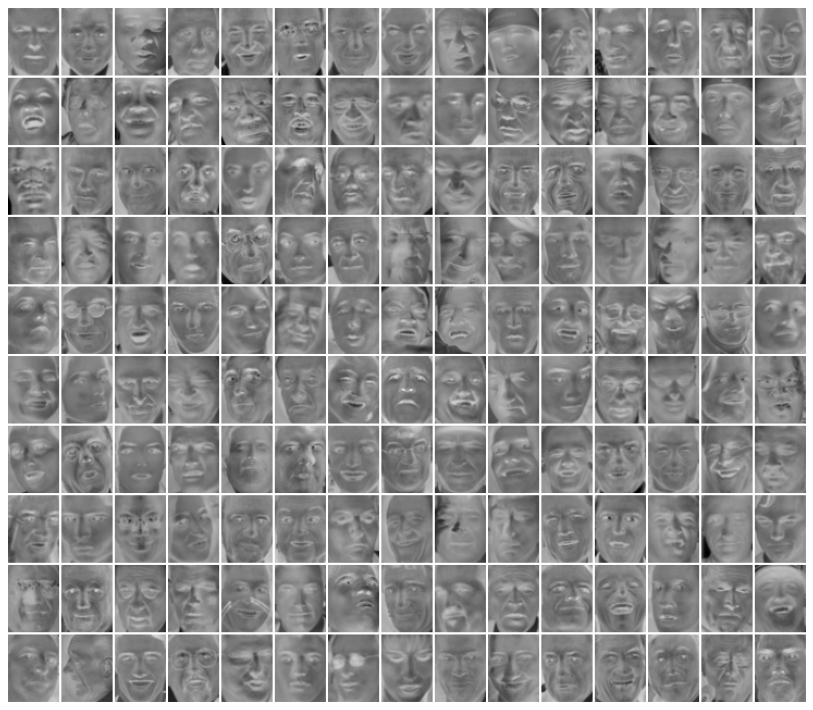

ValueError: operands could not be broadcast together with shapes (150,2914) (2914,150) 

In [822]:
B = vector[:, 1000].reshape([2914, 1])

B_pre = np.matmul(B, B.T)

final = np.matmul(B_pre, X_call).T - X_diff

ancho = 15
alto = 10#int(n_eigh/15)
utils.render(final,ancho,alto,vmax=5)  

_final = final - final_good

print(np.mean(_final))

In [ ]:
from numpy import linalg as LA
import time
na = np.newaxis

before = time.time()




MEAN = np.zeros([X.shape[1], X.shape[2]])
for X_k in X:
    MEAN = MEAN + X_k
MEAN = MEAN / X.shape[0]


S = np.zeros([X.shape[1], X.shape[1]])
for X_k in X:
    diff = X_k - MEAN
    S = S + np.matmul(diff, diff.T)
    

    
    
utils.render(S[:1],1,1,vmax=5)         
#S = S / X.shape[0]

#v, w = LA.eigh(S)

    
    
    
after = time.time()
print(after - before)
    
    


In [ ]:
from numpy import linalg as LA
import time
na = np.newaxis

before = time.time()

X_prima = X.reshape([X.shape[0], X.shape[1]*X.shape[2]])

X_mean = X_prima.mean(axis=0)

X_diff = (X_prima - X_mean).T

leng = 150
S = np.zeros([leng, leng])
for X_k in X_diff:
#    pre_S = np.matmul(X_k.reshape([leng, 1]), X_k.reshape([1, leng]))
    pre_S = X_k * X_k.T
    S = S + pre_S
S = S / 150
value, vector = LA.eigh(S)

idx = value.argsort()[::-1] # Sort descending and get sorted indices
value = value[idx] # Use indices on eigv vector
vector = vector[:,idx] # 

print(vector.shape)
final_value = np.dot(vector[:], X_diff.T)

#idx = v.argsort()[::-1] # Sort descending and get sorted indices
#v = v[idx] # Use indices on eigv vector
#w = w[:,idx] # 

X_final = final_value.reshape([150, X.shape[1], X.shape[2]])




print(vector[vector < 0])

print(X_final[X_final< 0])



utils.scatterplot(X_final[0],X_final[1], xlabel='PCA 1',ylabel='PCA 2')

utils.scatterplot(vector[:,0], vector[:, 1], xlabel='PCA 1',ylabel='PCA 2')




utils.render(X_final[:60],15,4,vmax=5)

print('X_prima: '+str(X_prima.shape))
print('X_mean: '+str(X_mean.shape))
print('X_diff: '+str(X_diff.shape))
print('S: '+str(S.shape))
print('final_value: '+str(final_value.shape))
print('X_final: '+str(X_final.shape))



print("X")
after = time.time()
print(after - before)

In [ ]:
import numpy as np
from scipy.stats.mstats import zscore
from sklearn.decomposition import PCA

def pca_code(data):
    #raw_implementation
    var_per=.98
    data-=np.mean(data, axis=0)
    # data/=np.std(data, axis=0)
    cov_mat=np.cov(data, rowvar=False)
    evals, evecs = np.linalg.eigh(cov_mat)

    idx = np.argsort(evals)[::-1]
    evecs = evecs[:,idx]
    evals = evals[idx]
    
    
    #variance_retained=np.cumsum(evals)/np.sum(evals)
    #index=np.argmax(variance_retained>=var_per)
    
    #evecs = evecs[:,:index+1]
    print(evecs[:,0].T.shape)
    print(data.T.shape)
    reduced_data=np.dot(evecs[:,0].T, data.T)
    print(reduced_data.shape)
    print("evals", evals)
    print("_"*30)
    print(evecs.T[1, :])
    print("_"*30)
    
    utils.scatterplot(evecs[:,0],evecs[:,1], xlabel='PCA 1',ylabel='PCA 2')
    
    utils.render(reduced_data,1,1,vmax=5)
    #using scipy package
    #clf=PCA(var_per)
    #X_train=data
    #X_train=clf.fit_transform(X_train)
    #print(clf.explained_variance_)
    #print("_"*30)
    #print(clf.components_[1,:])
    #print("__"*30)
    
    
Y = X.reshape([X.shape[0], X.shape[1]*X.shape[2]])
before = time.time()
pca_code(Y)
after = time.time()
print(after - before)
    

M: (150, 2914)
A: (2914, 150)
A.T: (150, 2914)
mean(A.T): (150,)
cov(M): (150, 150)
latent: (150,)
coeff: (150, 150)
coeff.T: (150, 150)
score: (150, 2914)
[]
0.010575056076049805
(150, 2914)
(150, 2914)


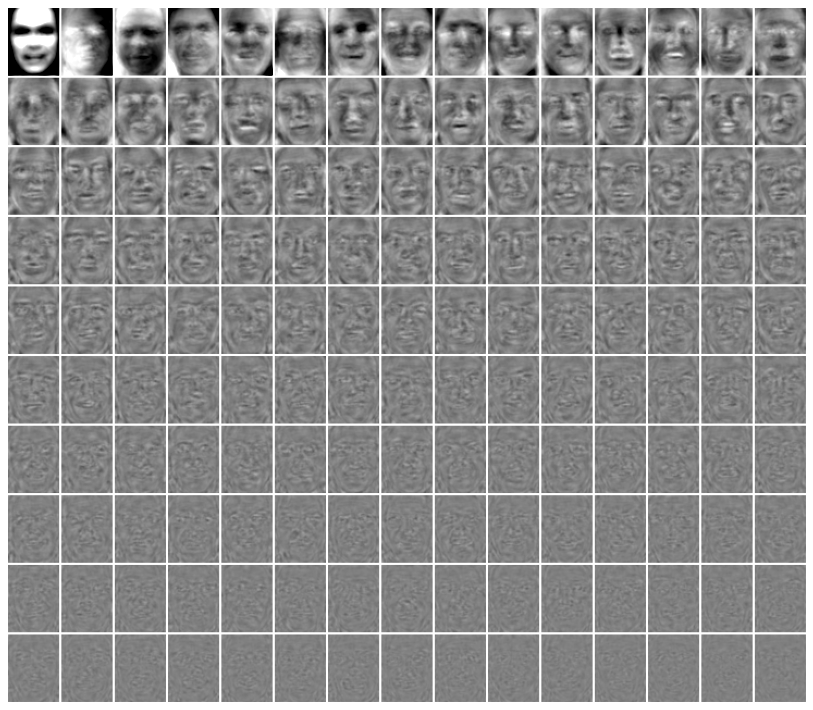

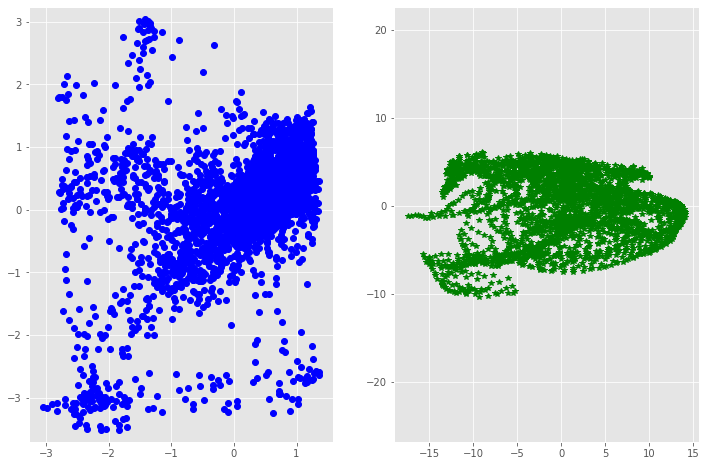

In [829]:
from numpy import mean,cov,double,cumsum,dot,linalg,array
from pylab import plot,subplot,axis,stem,show,figure
import time
def princomp(A):
    """performs principal components analysis 
         (PCA) on the n-by-p data matrix A
         Rows of A correspond to observations, columns to variables. 

     Returns :  
      coeff :
        is a p-by-p matrix, each column containing coefficients 
        for one principal component.
      score : 
        the principal component scores; that is, the representation 
        of A in the principal component space. Rows of SCORE 
        correspond to observations, columns to components.
      latent : 
        a vector containing the eigenvalues 
        of the covariance matrix of A.
    """
    # computing eigenvalues and eigenvectors of covariance matrix
    M = (A-mean(A.T,axis=1)).T # subtract the mean (along columns)
    
    


    cov_ = cov(M)
    #cov_ = S
    
    [latent,coeff] = linalg.eigh(cov_) # attention:not always sorted
    idx = np.argsort(latent)[::-1]
    coeff = coeff[:,idx]
    latent = latent[idx]
    
    
    
    
#    score = dot(coeff.T,M) # projection of the data in the new space
    
    score = np.matmul(coeff.T, M)

    #utils.scatterplot(coeff[:,0], coeff[:, 1], xlabel='PCA 1',ylabel='PCA 2')
    
    print('M: '+str(M.shape))
    print('A: '+str(A.shape))
    print('A.T: '+str(A.T.shape))
    print('mean(A.T): '+str(mean(A.T,axis=1).shape))
    print('cov(M): '+str(cov(M).shape))
    print('latent: '+str(latent.shape))
    print('coeff: '+str(coeff.shape))
    print('coeff.T: '+str(coeff.T.shape))
    print('score: '+str(score.shape))    
    
    
    print(coeff[coeff < -20])
    
    
    return coeff,score,latent

#A = array([ [2.4,0.7,2.9,2.2,3.0,2.7,1.6,1.1,1.6,0.9],
#            [2.5,0.5,2.2,1.9,3.1,2.3,2,1,1.5,1.1] ])

X_prima = X.reshape([X.shape[0], X.shape[1]*X.shape[2]])

A = X_prima

before = time.time()
coeff, score, latent = princomp(A.T)


after = time.time()
print(after - before)
print(score.shape)

lala = score
print(lala.shape)
utils.render(lala,15,10,vmax=5)



figure()
subplot(121)
# every eigenvector describe the direction
# of a principal component.
m = mean(A,axis=1)
plot([0, -coeff[0,0]*2]+m[0], [0, -coeff[0,1]*2]+m[1],'--k')
plot([0, coeff[1,0]*2]+m[0], [0, coeff[1,1]*2]+m[1],'--k')
plot(A[0,:],A[1,:],'ob') # the data
axis('equal')
subplot(122)
# new data
plot(score[0,:],score[1,:],'*g')
axis('equal')
show()

When looking at the scatter plot, we observe that much more variance is expressed in the first two principal components than in individual dimensions as it was plotted before. When looking at the principal components themselves which we render as images, we can see that the first principal components correspond to low-frequency filters that select for coarse features, and the following principal components capture progressively higher-frequency information and are also becoming more noisy.

## Iterative PCA (15 P)

The standard PCA method based on eigenvalues is quite expensive to compute. Instead, the power iteration algorithm looks only for the first component and finds it using an iterative procedure. It starts with an initial weight vector $\boldsymbol{w}$, and repeatedly applies the update rule

$$
\boldsymbol{w} \leftarrow S \boldsymbol{w} \,\big/\, \|S \boldsymbol{w}\|.
$$

Like for standard PCA, the objective that iterative PCA optimizes is $J(\boldsymbol{w}) = \boldsymbol{w}^\top S \boldsymbol{w}$ subject to the unit norm constraint for $\boldsymbol{w}$. We can therefore keep track of the progress of the algorithm after each iteration.

**Tasks:**

* **Implement the iterative PCA algorithm. Use as a stopping criterion the value of $J(\boldsymbol{w})$ between two iterations increasing by less than one.**
* **Print the value of the objective function $J(\boldsymbol{w})$ at each iteration.**
* **Measure the time taken to find the principal component.**
* **Visualize the the eigenvector $\boldsymbol{w}$ obtained after convergence using the function `utils.render`.**

Note that if the algorithm runs for more than 1 minute, there may be some error in your implementation.

In [ ]:
### REPLACE BY YOUR CODE
import solutions; solutions.iterative(X)
###

We observe that the computation time has decreased significantly. The difference of performance becomes larger as the number of dimensions increases. We can observe that the principal component is the same (sometimes up to a sign flip) as the one obtained by standard PCA.

In [728]:
A = np.matrix([[1,2,3,4],
               [5,5,6,7],
               [1,4,2,3],
               [5,3,2,1],
               [8,1,2,2]])

df = pd.DataFrame(A,columns  = ['f1','f2','f3','f4'])
df

NameError: name 'pd' is not defined